<a href="https://colab.research.google.com/github/mauro3/EGU2025-Julia-intro-and-showcase-for-geoscience/blob/main/glacier-inverse-modelling/glacier_inverse_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inverse glacier modelling on graphics processing units (GPUs)
_by Ludovic Räss, Ivan Utkin, Mauro Werder & friends_

As preliminary step, let's prepare the Julia environment as it may take some time to get things ready.
1. First, check what packages are already installed on the GPU cloud instance, and activate a local project environment:

In [1]:
import Pkg
Pkg.status()
Pkg.activate(pwd())

Status `~/.julia/environments/v1.11/Project.toml`
  [da04e1cc] MPI v0.20.22


  Activating new project at `/work/lraess/EGU2025-Julia-intro-and-showcase-for-geoscience/glacier-inverse-modelling`


2. Then, let's add the packages we will need:

In [2]:
Pkg.add(url="https://github.com/yiluchen1066/Glaide.jl")
Pkg.add(["CairoMakie", "JLD2", "Unitful"])

     Cloning git-repo `https://github.com/yiluchen1066/Glaide.jl`
    Updating git-repo `https://github.com/yiluchen1066/Glaide.jl`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed CRlibm ───────────── v1.0.2
   Installed ExpressionExplorer ─ v1.1.3
   Installed Parsers ──────────── v2.8.3
   Installed IntervalArithmetic ─ v0.22.30
    Updating `/work/lraess/EGU2025-Julia-intro-and-showcase-for-geoscience/glacier-inverse-modelling/Project.toml`
  [86ebb91d] + Glaide v0.2.2 `https://github.com/yiluchen1066/Glaide.jl#main`
    Updating `/work/lraess/EGU2025-Julia-intro-and-showcase-for-geoscience/glacier-inverse-modelling/Manifest.toml`
  [621f4979] + AbstractFFTs v1.5.0
  [6e696c72] + AbstractPlutoDingetjes v1.3.2
  [1520ce14] + AbstractTrees v0.4.5
  [79e6a3ab] + Adapt v4.3.0
  [35492f91] + AdaptivePredicates v1.2.0
  [66dad0bd] + AliasTables v1.1.3
  [27a7e980] + Animations v0.4.2
  [c9ce4bd3] + ArchGDAL v0.10.8
  [dce04be8] + A

3. Now we have all we need, let's use them

In [3]:
using Glaide, CairoMakie, Printf, JLD2, CUDA, Unitful

In [4]:
# Select GPU
CUDA.device!(1)

CuDevice(1): Tesla V100-SXM2-32GB

> ### 💡 Before getting started
>
> - This notebook is a stripped down version of a somewhat longer modelling workflow skipping the data preparation and only showcasing a so-called "snapshot" inversion of the spatial distribution of the basal sliding coefficient for the Aletsch glacier in the Swiss Alps;
> - The notebook calls into the [Glaide.jl](https://github.com/yiluchen1066/Glaide.jl) Julia package that implements most of the compute;
> - The code requires a Nvidia CUDA-capable GPU to execute on;
> - The content is part of a paper recently accepted and soon available online in the Journal of Glaciology (link to pre-revision preprint: http://dx.doi.org/10.22541/essoar.172798784.45298378/v1).

## Inverse glacier modelling

For this short demo, we are interested in constraining the spatial distribution of a glacier sliding coefficient $A_\mathrm{s}$. This sliding occurs at the ice-bedrock interface and may enhance glacier flow beyond the pure viscous flow deformation of the bulk of the ice. As a result, one may observe surface ice velocities that differ from values predicted by a purely viscous ice flow model with the basal ice being frozen to the bed.

To achieve our goals, we will implement an optimisation workflow that employs automatic differentiation (AD) to generate adjoint code and runs in parallel on graphics processing units (GPUs).

AD is a powerfull tool that enables us to retrieve gradients (or derivatives) of Julia code in an automated fashion. We rely on [Enzyme.jl,](https://github.com/EnzymeAD/Enzyme.jl) a high-performance automatic differentiator of LLVM (the Julia "compiler").

## The Aletsch glacier dataset

In this demo, we will target the Aletsch glacier in the Swiss Alps. In order to keep the material concise, we have prepared a dataset that can be readily downloaded from Zenodo. The pre-processing workflow is available as an interactive [Pluto.jl](https://plutojl.org/) notebook [generate_aletsch_setup.jl](https://github.com/yiluchen1066/Glaide.jl/blob/main/app/generate_aletsch_setup.jl), which is part of the Glaide.jl package.

Let's download the pre-processed file `aletsch_25m.jld2` (saved as [JLD2](https://github.com/JuliaIO/JLD2.jl) - a Julia HDF5 format), save it locally to the userspace and then visualise it using [CairoMakie](https://docs.makie.org/stable/explanations/backends/cairomakie).

In [5]:
dataset_url = "https://zenodo.org/api/records/15279196/files-archive"
datasets_dir = "./datasets"
dataset_name = "aletsch_25m.jld2"
download_raster(dataset_url, dataset_name, joinpath(datasets_dir, dataset_name))

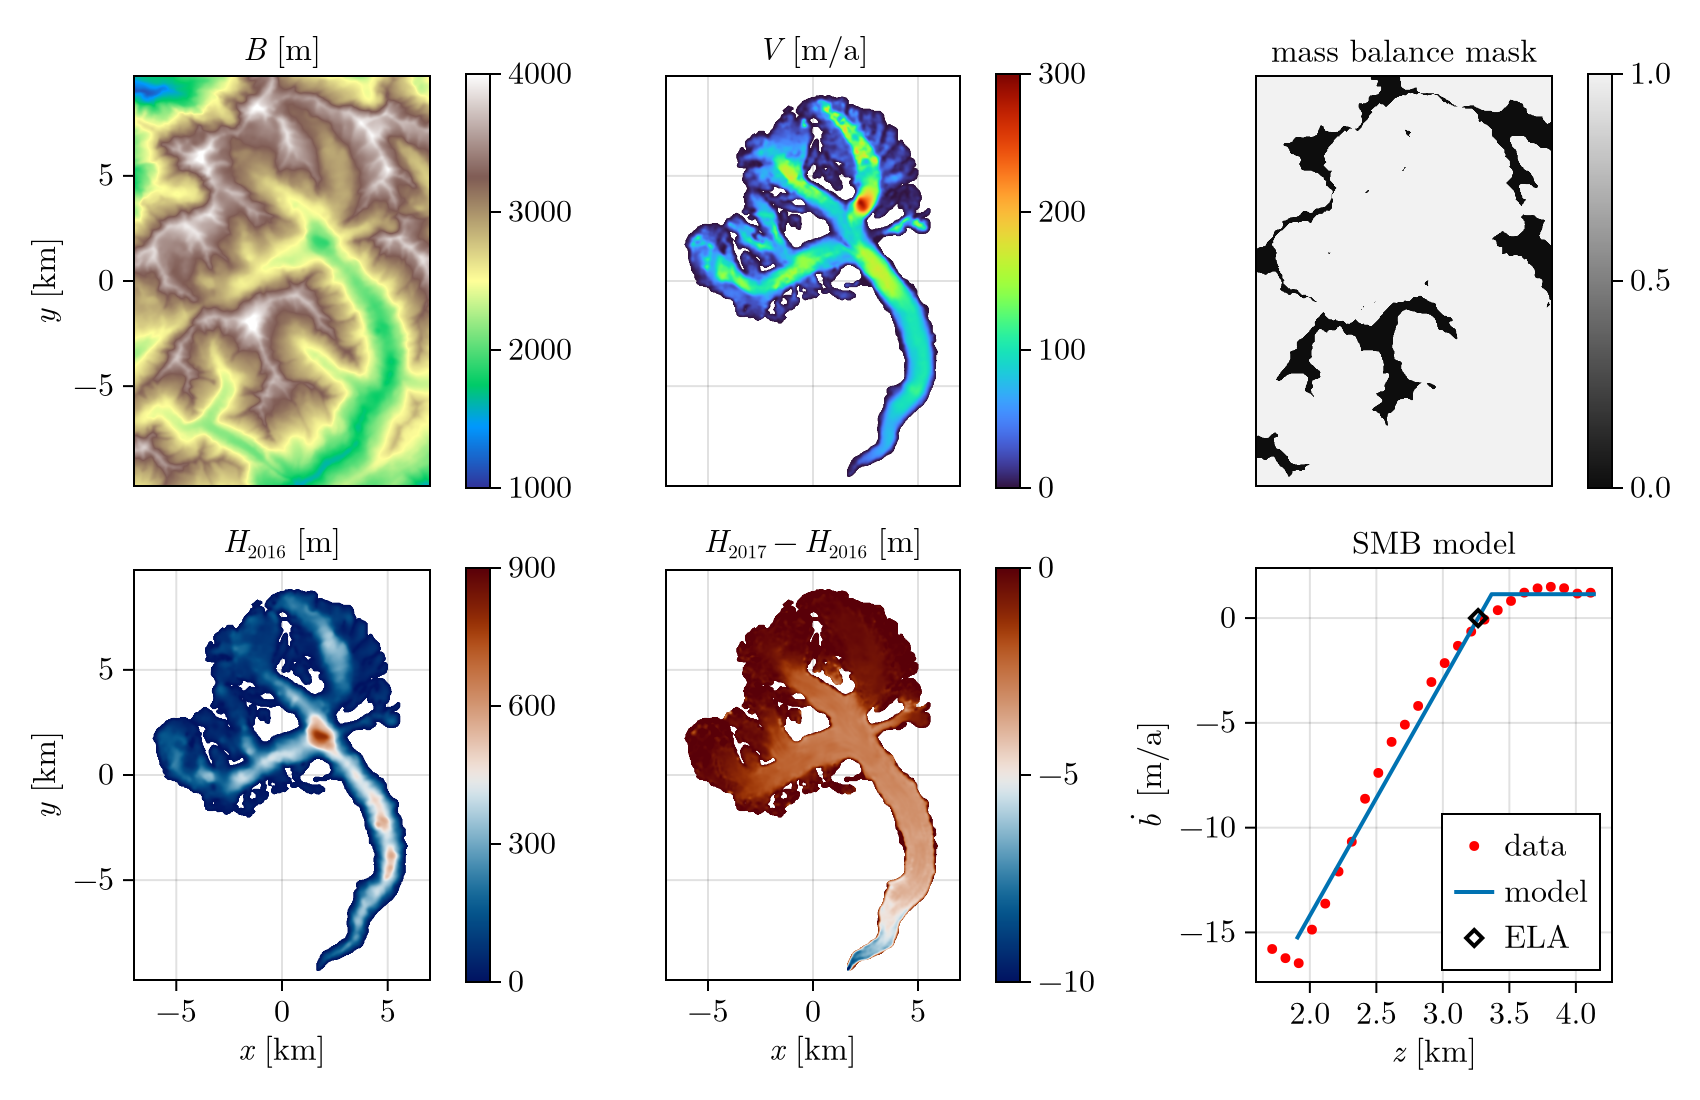

In [6]:
with_theme(theme_latexfonts()) do
    # visualise the highest resolution (25m)
    vis_path = joinpath(datasets_dir, dataset_name)

    fields, scalars, numerics, eb, mb = load(vis_path, "fields",
                                                       "scalars",
                                                       "numerics",
                                                       "eb",
                                                       "mb")


    fig = Figure(; size=(850, 550), fontsize=16)

    # convert to km
    x_km = ustrip.(u"km", numerics.xc .* L_REF)
    y_km = ustrip.(u"km", numerics.yc .* L_REF)

    axs = (Axis(fig[1, 1][1, 1]; aspect=DataAspect()),
           Axis(fig[1, 2][1, 1]; aspect=DataAspect()),
           Axis(fig[2, 1][1, 1]; aspect=DataAspect()),
           Axis(fig[2, 2][1, 1]; aspect=DataAspect()),
           Axis(fig[1, 3][1, 1]; aspect=DataAspect()),
           Axis(fig[2, 3]      ; title=L"\text{SMB model}"))

    colgap!(fig.layout, 1, Relative(0.08))

    axs[1].title = L"B~\mathrm{[m]}"
    axs[2].title = L"V~\mathrm{[m/a]}"
    axs[3].title = L"H_{2016}~\mathrm{[m]}"
    axs[4].title = L"H_{2017} - H_{2016}~\mathrm{[m]}"
    axs[5].title = L"\text{mass balance mask}"

    axs[3].xlabel = L"x~\mathrm{[km]}"
    axs[4].xlabel = L"x~\mathrm{[km]}"

    axs[1].ylabel = L"y~\mathrm{[km]}"
    axs[3].ylabel = L"y~\mathrm{[km]}"

    axs[6].xlabel = L"z~\mathrm{[km]}"
    axs[6].ylabel = L"\dot{b}~\mathrm{[m/a]}"

    hidexdecorations!.((axs[1], axs[2], axs[5]))
    hideydecorations!.((axs[2], axs[4], axs[5]))

    axs[2].xgridvisible=true
    axs[2].ygridvisible=true
    axs[4].ygridvisible=true

    fields.V     .= ustrip.(u"m/yr", fields.V     .* L_REF / T_REF)
    fields.B     .= ustrip.(u"m"   , fields.B     .* L_REF)
    fields.H_old .= ustrip.(u"m"   , fields.H_old .* L_REF)
    fields.H     .= ustrip.(u"m"   , fields.H     .* L_REF)

    # cut off everything where the ice thickness is less than 1m
    ice_mask = fields.H .< 1.0

    fields.V[ice_mask]     .= NaN
    fields.H_old[ice_mask] .= NaN
    fields.H[ice_mask]     .= NaN

    hms = (heatmap!(axs[1], x_km, y_km, fields.B),
           heatmap!(axs[2], x_km, y_km, fields.V),
           heatmap!(axs[3], x_km, y_km, fields.H_old),
           heatmap!(axs[4], x_km, y_km, fields.H .- fields.H_old ),
           heatmap!(axs[5], x_km, y_km, fields.mb_mask))

    foreach(hms) do h
        h.interpolate = true
    end

    hms[1].colormap = :terrain
    hms[2].colormap = :turbo
    hms[3].colormap = :vik
    hms[4].colormap = :vik
    hms[5].colormap = :grays

    hms[1].colorrange = (1000, 4000)
    hms[2].colorrange = (0, 300)
    hms[3].colorrange = (0, 900)
    hms[4].colorrange = (-10, 0)

    z    = (LinRange(1900, 4150, 1000) * u"m") ./ L_REF .|> NoUnits
    mb_f = @. min(scalars.b * (z - scalars.ela), scalars.mb_max)

    # observational mass balance data
    scatter!(axs[6], ustrip.(u"km"  , eb * u"m"),
                     ustrip.(u"m/yr", mb * u"m/s"); markersize=7,
                                                    color=:red,
                                                    label="data")

    # parametrised model
    lines!(axs[6], ustrip.(u"km"  , z    * L_REF),
                   ustrip.(u"m/yr", mb_f * L_REF / T_REF); linewidth=2,
                                                           label="model")

    ela = ustrip(u"km", scalars.ela * L_REF)

    scatter!(axs[6], ela, 0; strokecolor=:black,
                             strokewidth=2,
                             color=:transparent,
                             marker=:diamond,
                             label="ELA")

    axislegend(axs[6]; position=:rb)

    cb = (Colorbar(fig[1, 1][1, 2], hms[1]),
          Colorbar(fig[1, 2][1, 2], hms[2]),
          Colorbar(fig[2, 1][1, 2], hms[3]),
          Colorbar(fig[2, 2][1, 2], hms[4]),
          Colorbar(fig[1, 3][1, 2], hms[5]))

    fig
end

The figure contains 6 panels, depicting:
- the bedrock elevation [m] asl
- the measured surface velocity magnitude [m/a]
- the mass-balance mask (ice free and high-altitude regions where we do not allow for accumulation/ablation)
- the ice thickness in the year 2016
- the changes in ice thickness (ablation/accumulation) over the 2016 - 2017 period
- the mass-balance data and corresponding simplified bi-linear model

## Objective

We are now interested in using a forward ice flow model to predict surface velocity magnitude on the Aletsch glacier, and implement an optimisation procedure to constrain the basal sliding coefficient in order to make the numerically predicted velocity field match the surface velocity data.

## Ice flow model

We use the isothermal shallow ice approximation (SIA) as the forward model.

According to the SIA, the surface velocity $V$ is given by:

$$
V = \left(\rho g\right)^n \left[\frac{2}{n+1} A H^{n+1} + A_\mathrm{s} H^n \right] \left| \nabla S \right|^{n}~,
$$

where $S = B + H$ is the ice surface elevation, $B$ is the bed elevation, $\rho$ is the ice density, $g$ is the gravitational acceleration, $A$ is the ice-flow parameter, $A_\mathrm{s}$ is the sliding parameter and $n$ is Glen's flow law exponent. The first term in brackets represents the flow due to ice deformation and the second term due to sliding following a Weertman-like sliding law where all constants are lumped into $A_\mathrm{s}$.

To account for the discrepancies introduced by using the simplified ice flow description, we introduce the correction factor $E$ to define the ice flow parameter $A$:

$$
A = E A_0~,
$$

where $A_0$ is the reference value of the ice flow parameter. Value of $E$ vary depending on the problem setup, but stay constant in time and space, assuming that most of the variability in the results can be attributed to the local changes in sliding.

The evolution of the ice thickness $H$ is described by the depth-averaged mass conservation equation:

$$
\frac{\partial H}{\partial t} = -\nabla \cdot \boldsymbol{q} + \dot{b} ~,
$$

where $\boldsymbol{q}$ is the horizontal ice flux and $\dot{b}$ is the volumetric surface mass balance rate, i.e. the rate of ice accumulation and ablation at a point. The horizontal ice flux $\boldsymbol{q}$ is defined as the vertically integrated velocity field:

$$
\boldsymbol{q} = \int_{B}^{S}\boldsymbol{V}(z)\,\mathrm{d}z~.
$$

We define the surface mass-balance $\dot{b}$ as:

$$
\dot{b} = \min \left\{ c (S - z_\mathrm{ELA}), ~\dot{b}_\mathrm{max} \right\} ~,
$$

where $c$ is the mass-balance rate gradient, $S$ is the surface elevation, $z_\mathrm{ELA}$ is the equilibrium line altitude, and $\dot{b}_\mathrm{max}$ is the maximum ice accumulation rate.

The ice flow equation can be regarded as a non-linear diffusion-reaction equation with a non-linear diffusion coefficient $D$ and horizontal diffusion flux $\boldsymbol{q}$:

\begin{gather}
    \boldsymbol{q} = -D ~ \nabla S ~, \\[10pt]
    D = (\rho g)^n \left[\frac{2}{n+2} A H^{n+2} + A_\mathrm{s} H^{n+1}\right] \left|\nabla S\right|^{n-1} ~,
\end{gather}

which we numerically solve using the [accelerated pseudo-transient (APT) method](https://gmd.copernicus.org/articles/15/5757/2022/). At the boundaries of the computational domain, we specify "zero-flux" boundary conditions: $\boldsymbol{q}\cdot\boldsymbol{n} = 0$, where $\boldsymbol{n}$ is the normal to the boundary.

## Snapshot inversion

In this example, we will use inverse modelling routine implemented in Glaide.jl to reconstruct spatially variable sliding parameter $A_\mathrm{s}$. The inverse modelling problem is defined as a minimisation problem with the following objective functional:

$$
J(A_\mathrm{s}) = \frac{\omega_V}{2}\sum_i\left(V_i(A_\mathrm{s}) - V^\mathrm{obs}_i\right)^2 + \frac{\gamma}{2}\sum_i\left(\nabla A_{\mathrm{s}_i}\right)^2~,
$$

where $\omega_V$ is the normalisation factor and $\gamma$ is the Tikhonov regularisation parameter.

The normalisation constant is defined as the inverse of the $L_2$-norm of the observed velocity field:

$$
\omega_V = \left[\sum_i\left(V^\mathrm{obs}_i\right)^2\right]^{-1}
$$

### Configuration

Define the type encapsulating the properties of the inversion that might be different between cases. In this study, these are the path to the input file and the enhancement factor $E$, which is needed to reduce the influence of the ice deformation in the Aletsch case:

In [7]:
Base.@kwdef struct InversionScenarioSnapshot
    input_file::String
    output_dir::String
    E::Float64 = 1.0
end

InversionScenarioSnapshot

Define the initial guess for the sliding parameter:

In [8]:
As_init = 1e-22u"Pa^-3*s^-1*m"

1.0e-22 m Pa^-3 s^-1

Define the regularisation parameter:

In [9]:
γ_reg = 1e-6;

Define the maximum number of iterations in the optimisation algorithm:

In [10]:
maxiter = 1000;

Define the parameters of the line search. Here, we only configure the minimal and maximal step size. In Glaide, the two-way backtracking line search based on Armijo-Goldstein condition is implemented. If in the line search loop the step size decreases below $\alpha_\mathrm{min}$, the optimisation stops with an error. If the step size increases above $\alpha_\mathrm{max}$, line search accepts $\alpha_\mathrm{max}$ as the step size. Increasing $\alpha_\mathrm{max}$ might improve convergence rate in some cases, but can also lead to instabilities and convergence issues in the forward solver.

In [11]:
line_search = BacktrackingLineSearch(; α_min=1e2, α_max=1e6);

### Inversion function

Here, we create a function that executes the inversion scenario:

In [12]:
function run_inversion(scenario::InversionScenarioSnapshot)
    model = SnapshotSIA(scenario.input_file)

    model.scalars.ρgnA *= scenario.E

    V_obs = copy(model.fields.V)

    ωᵥ = inv(sum(V_obs .^ 2))

    objective = SnapshotObjective(ωᵥ, V_obs, γ_reg)

    # see cells below for details on how the callback is implemented
    callback = Callback(model, scenario, V_obs)
    options  = OptimisationOptions(; line_search, callback, maxiter)

    n = model.scalars.n

    # initial guess
    ρgnAs_init = RHOG^n * As_init * (L_REF^(n-1) * T_REF) |> NoUnits
    log_ρgnAs0 = CUDA.fill(log(ρgnAs_init), size(V_obs))

    # inversion
    optimise(model, objective, log_ρgnAs0, options)

    # show animation
    return callback.video_stream
end;

### Some comments on the above code:

- We initialise the observed velocity field `V_obs` with `model.fields.V`. This is because the observed velocity is stored in the model's field `V`, as implemented in the notebook [`generate_aletsch_setup.jl`](https://github.com/yiluchen1066/Glaide.jl/blob/main/app/generate_aletsch_setup.jl);
- We create the callback object `callback = Callback(model, obs)`. The definition of `Callback` is a bit convoluted, but in short, it handles the debug visualisation, keeping track of the convergence history, and saving the intermediate results of the optimisation. The details of the callback objects are shown hereafter.

In [13]:
mutable struct Callback{M,S,JH}
    model::M
    scenario::S
    j_hist::JH
    fig::Figure
    axs
    hms
    lns
    cbs
    video_stream
    step::Int

    function Callback(model, scenario, V_obs)
        j_hist = Point2{Float64}[]

        fig = Figure(; size=(800, 850))

        axs = (Axis(fig[1, 1][1, 1]; aspect=DataAspect()),
               Axis(fig[1, 2][1, 1]; aspect=DataAspect()),
               Axis(fig[2, 1][1, 1]; aspect=DataAspect()),
               Axis(fig[2, 2][1, 1]; aspect=DataAspect()),
               Axis(fig[3, :]; yscale=log10))

        axs[1].title = "log10(As)"
        axs[2].title = "dJ/d(logAs)"
        axs[3].title = "V_obs"
        axs[4].title = "V"
        axs[5].title = "Convergence"

        axs[5].xlabel = "Iteration";
        axs[5].ylabel = "J"

        xc_km = ustrip.(u"km", model.numerics.xc .* L_REF)
        yc_km = ustrip.(u"km", model.numerics.yc .* L_REF)

        n     = model.scalars.n
        ρgnAs = model.fields.ρgnAs
        V     = model.fields.V

        As_v    = ustrip.(u"Pa^-3*s^-1*m", ρgnAs .* (L_REF^(1-n) * T_REF^(-1) / RHOG^n))
        V_obs_v = ustrip.(u"m/yr", V_obs .* (L_REF / T_REF))
        V_v     = ustrip.(u"m/yr", V     .* (L_REF / T_REF))

        hms = (heatmap!(axs[1], xc_km, yc_km, Array(log10.(As_v))),
               heatmap!(axs[2], xc_km, yc_km, Array(log10.(As_v))),
               heatmap!(axs[3], xc_km, yc_km, Array(V_obs_v)),
               heatmap!(axs[4], xc_km, yc_km, Array(V_v)))

        hms[1].colormap = Makie.Reverse(:roma)
        hms[2].colormap = Makie.Reverse(:roma)
        hms[3].colormap = :turbo
        hms[4].colormap = :turbo

        hms[1].colorrange = (-24, -20)
        hms[2].colorrange = (-1e-8, 1e-8)
        hms[3].colorrange = (0, 300)
        hms[4].colorrange = (0, 300)

        lns = (lines!(axs[5], Point2{Float64}[]), )

        cbs = (Colorbar(fig[1, 1][1, 2], hms[1]),
               Colorbar(fig[1, 2][1, 2], hms[2]),
               Colorbar(fig[2, 1][1, 2], hms[3]),
               Colorbar(fig[2, 2][1, 2], hms[4]))

        new{typeof(model), typeof(scenario), typeof(j_hist)}(model,
                                                             scenario,
                                                             j_hist,
                                                             fig,
                                                             axs,
                                                             hms,
                                                             lns,
                                                             cbs,
                                                             nothing, 0)
    end
end

function (cb::Callback)(state::OptmisationState)
    if state.iter == 0
        empty!(cb.j_hist)
        cb.video_stream = VideoStream(cb.fig; framerate=10)
        cb.step = 0

        mkpath(cb.scenario.output_dir)
    end

    push!(cb.j_hist, Point2(state.iter, state.j_value))

    if state.iter % 10 == 0
        @info @sprintf("iter #%-4d, J = %1.3e, ΔJ/J = %1.3e, ΔX/X = %1.3e, α = %1.3e\n", state.iter,
                  state.j_value,
                  state.j_change,
                  state.x_change,
                  state.α)

        n     = cb.model.scalars.n
        ρgnAs = cb.model.fields.ρgnAs
        V     = cb.model.fields.V

        coef = (L_REF^(1-n) * T_REF^(-1) / RHOG^n)

        As_v = ustrip.(u"Pa^-3*s^-1*m", ρgnAs .* coef)
        V_v  = ustrip.(u"m/yr", V .* (L_REF / T_REF))


        cb.hms[1][3] = Array(log10.(As_v))
        cb.hms[2][3] = Array(state.X̄ ./ log10(ℯ))
        cb.hms[4][3] = Array(V_v)
        cb.lns[1][1] = cb.j_hist
        autolimits!(cb.axs[5])
        recordframe!(cb.video_stream)

        output_path = joinpath(cb.scenario.output_dir, @sprintf("step_%04d.jld2", cb.step))

        jldsave(output_path;
                X=Array(state.X),
                X̄=Array(state.X̄),
                V=Array(cb.model.fields.V),
                H=Array(cb.model.fields.H),
                iter=state.iter,
                j_hist=cb.j_hist,)

        cb.step += 1
    end
    return
end

### Aletsch inversion

Then, we create the inversion scenario to reconstruct the distribution of the sliding parameter at the base of the Aletsch glacier. There, using the standard parameters for the flow parameter $A = 2.5\times10^{-24}\,\text{Pa}\,\text{s}^{-3}$ result in the surface velocity values much higher than the observed ones even without any sliding. This is likely due to using the SIA model that doesn't account for longitudinal stresses and non-hydrostatic pressure variations. We correct this by introducing a flow enhancement factor $E = 0.25$:

In [14]:
aletsch_scenario = InversionScenarioSnapshot(;
    input_file = "./datasets/aletsch_25m.jld2",
    output_dir = "./output/snapshot_aletsch_25m",
    E = 0.25
);

#### Run the inversion:

In [15]:
run_inversion(aletsch_scenario)

┌ Info: iter #0   , J = 4.244e+00, ΔJ/J = NaN, ΔX/X = NaN, α = 1.000e+02
└ @ Main /home/lraess/work/EGU2025-Julia-intro-and-showcase-for-geoscience/glacier-inverse-modelling/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X44sdnNjb2RlLXJlbW90ZQ==.jl:90
┌ Warning: line search failed to find a suitable step size
└ @ Glaide /home/lraess/.julia/packages/Glaide/dJijt/src/optimise.jl:185
┌ Info: iter #10  , J = 7.340e-01, ΔJ/J = 1.373e-02, ΔX/X = 9.871e-05, α = 6.400e+03
└ @ Main /home/lraess/work/EGU2025-Julia-intro-and-showcase-for-geoscience/glacier-inverse-modelling/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X44sdnNjb2RlLXJlbW90ZQ==.jl:90
┌ Info: iter #20  , J = 6.677e-01, ΔJ/J = 6.384e-03, ΔX/X = 7.366e-05, α = 1.280e+04
└ @ Main /home/lraess/work/EGU2025-Julia-intro-and-showcase-for-geoscience/glacier-inverse-modelling/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X44sdnNjb2RlLXJlbW90ZQ==.jl:90
┌ Info: iter #30  , J = 6.361e-01, ΔJ/J = 3.668e-03, ΔX/X = 1.851e-04, α = 1.28

VideoStream(Base.PipeEndpoint(RawFD(97) open, 0 bytes waiting), Process(setenv(`/home/lraess/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin/ffmpeg -y -loglevel quiet -threads 16 -framerate 10 -pixel_format rgb24 -f rawvideo -s:v 1600x1700 -r 10 -i pipe:0 -vf vflip -profile:v high422 -crf 20 -preset slow -c:v libx264 -pix_fmt yuv420p -an '/tmp/jl_Of06nd/##video#1078.mp4'`,["_CE_M=", "ENV=/soft/modules/init/profile.sh", "PATH=/home/lraess/.julia/artifacts/b8a470e4553346122607f94ec60d83c77f061cd6/bin:/home/lraess/.julia/artifacts/7f882b869c126a717e15be05453b83bd9135eab0/bin:/home/lraess/.julia/artifacts/96bc7b9ddb319d1a051535c85184aa2bf42dbd8b/bin:/home/lraess/.julia/artifacts/2a6bae048c28452d329375cbb7479499115e45ad/bin:/home/lraess/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/bin:/home/lraess/.julia/artifacts/0b5269206a6849e48487ed04136c30b1f12443e7/bin:/home/lraess/.julia/artifacts/bdb4015047b09c6ac5002f73dfd5be8ddf59189b/bin:/home/lraess/.julia/artifacts/00023f2f62a04af7531278ce1a689ff93800ffa1/bin:/home/lraess/.julia/artifacts/a696e1e3e6b8d3c2c4b67609357ebc5c35eabde1/bin:/home/lraess/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin:/home/lraess/.vscode-server/cli/servers/Stable-17baf841131aa23349f217ca7c570c76ee87b957/server/bin/remote-cli:/soft/openmpi/gcc83/316_c112/bin:/soft/cuda/12.1/bin:/home/lraess/.juliaup/bin:/home/lraess/anaconda3/condabin:/soft/modules/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/home/lraess/bin:/soft/bin", "VSCODE_HANDLES_SIGPIPE=true", "ELECTRON_RUN_AS_NODE=1", "BASH_FUNC_ml%%=() {  module ml \"\$@\"\n}", "MODULEPATH_modshare=/soft/modules/modulefiles:1", "HISTSIZE=1000", "VSCODE_NLS_CONFIG={\"userLocale\":\"en\",\"osLocale\":\"en\",\"resolvedLanguage\":\"en\",\"defaultMessagesFile\":\"/home/lraess/.vscode-server/cli/servers/Stable-17baf841131aa23349f217ca7c570c76ee87b957/server/out/nls.messages.json\",\"locale\":\"en\",\"availableLanguages\":{}}", "CONDA_PYTHON_EXE=/home/lraess/anaconda3/bin/python"  …  "JULIA_LOAD_PATH=:/soft/julia/julia_prefs/", "SSL_CERT_DIR=/etc/pki/tls/certs", "_CE_CONDA=", "CONDA_SHLVL=0", "CONDA_EXE=/home/lraess/anaconda3/bin/conda", "HOME=/home/lraess", "VSCODE_CLI_REQUIRE_TOKEN=222ba6c4-a827-4158-b092-9eea32c42d54", "OPENBLAS_MAIN_FREE=1", "S_COLORS=auto", "HOSTNAME=node40.octopoda"]), ProcessRunning), CairoMakie.Screen{CairoMakie.IMAGE}(Scene (800px, 850px):
  0 Plots
  9 Child Scenes:
    ├ Scene (800px, 850px)
    ├ Scene (800px, 850px)
    ├ Scene (800px, 850px)
    ├ Scene (800px, 850px)
    ├ Scene (800px, 850px)
    ├ Scene (800px, 850px)
    ├ Scene (800px, 850px)
    ├ Scene (800px, 850px)
    └ Scene (800px, 850px), Cairo.CairoSurfaceImage{ColorTypes.ARGB32}(Ptr{Nothing} @0x00000000129c0400, 1600.0, 1700.0, ColorTypes.ARGB32[ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) … ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8); ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) … ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8); … ; ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) … ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8); ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) … ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8)]), Cairo.CairoContext(Ptr{Nothing} @0x000000000ea62030, Cairo.CairoSurfaceImage{ColorTypes.ARGB32}(Ptr{Nothing} @0x00000000129c0400, 1600.0, 1700.0, ColorTypes.ARGB32[ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) … ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8); ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) … ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8); … ; ARGB32(1.0N0f8,1.0N0f8,1.0N0f8,1.0N0f8) ARGB32(1.0N0f8,1